In [163]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn import metrics as skmetrics
import scipy.stats

In [164]:
model = gensim.models.Word2Vec.load('/home/bahbbc/workspace/masters-big5/models/tweet50-300-skip.model')
model.init_sims(replace=True)

2017-07-01 21:13:09,043 : INFO : loading Word2Vec object from /home/bahbbc/workspace/masters-big5/models/tweet50-300-skip.model
2017-07-01 21:13:15,950 : INFO : loading wv recursively from /home/bahbbc/workspace/masters-big5/models/tweet50-300-skip.model.wv.* with mmap=None
2017-07-01 21:13:15,951 : INFO : loading syn0 from /home/bahbbc/workspace/masters-big5/models/tweet50-300-skip.model.wv.syn0.npy with mmap=None
2017-07-01 21:13:19,845 : INFO : setting ignored attribute syn0norm to None
2017-07-01 21:13:19,846 : INFO : loading syn1neg from /home/bahbbc/workspace/masters-big5/models/tweet50-300-skip.model.syn1neg.npy with mmap=None
2017-07-01 21:13:28,586 : INFO : setting ignored attribute cum_table to None
2017-07-01 21:13:28,600 : INFO : loaded /home/bahbbc/workspace/masters-big5/models/tweet50-300-skip.model
2017-07-01 21:13:32,348 : INFO : precomputing L2-norms of word weight vectors


In [165]:
num_features= 300

In [166]:
df = pd.read_csv('~/personality-normalized-word2vec-norm.csv', encoding='utf-8')
df.shape

(1039, 186)

In [167]:
train_w2v_data, test_w2v_data = train_test_split(df, test_size=0.3, random_state=42)

In [168]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    #print words.shape
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)
        #print mean

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(num_features,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [169]:
def w2v_tokenize_text(text):
    tokens = []
    if text is np.nan:
        return []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            if word in stopwords.words('portuguese'):
                continue
            tokens.append(word)
    return tokens

In [170]:
test_tokenized = test_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [171]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

2017-07-01 21:18:25,370 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:25,634 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:25,639 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:26,153 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:26,356 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:26,660 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:27,252 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:27,329 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:27,514 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:27,649 : WARNING : cannot compute similarity with no input []
2017-07-01 21:18:27,698 : WARNING : cannot compute similarity with no input []


CPU times: user 3.16 s, sys: 17.4 ms, total: 3.18 s
Wall time: 3.21 s


In [172]:
del model

In [173]:
X_train_word_average.shape

(727, 300)

In [174]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals import joblib

force = False
model_trainer = RandomizedSearchCV(
    n_iter=1, 
    estimator=DecisionTreeRegressor(),
    param_distributions={
        "max_features": ["log2"],
        "random_state": [42],
        "criterion":['mse']
    },
    verbose=True,
    refit=True,
    cv=10,
    n_jobs=-1
)


## Extraversion evaluation

In [175]:
df.extraversion.astype('int').value_counts()

3    418
2    332
4    191
1     95
5      3
Name: extraversion, dtype: int64

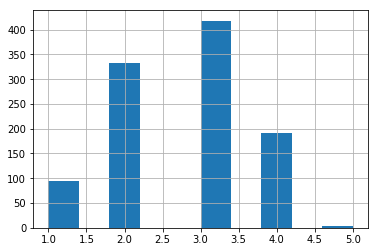

In [176]:
df.extraversion.astype('int').hist()

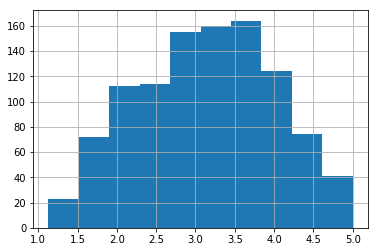

In [177]:
df.extraversion.hist()

In [178]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['extraversion'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 298 ms, sys: 150 ms, total: 448 ms
Wall time: 485 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [179]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['extraversion']

In [180]:
(yt > 5).sum()

0

In [181]:
yp[:10]

array([ 3.25,  4.  ,  4.13,  4.13,  2.63,  4.13,  2.25,  2.75,  3.25,  3.5 ])

In [182]:
yt[:10]

310     4.00
809     3.00
309     3.50
31      3.75
544     3.25
96      3.63
883     2.88
109     2.75
833     4.63
1034    3.13
Name: extraversion, dtype: float64

In [183]:
skmetrics.mean_squared_error(yt, yp)

1.2232979077635326

In [184]:
skmetrics.r2_score(yt, yp)

-0.70217623651573624

In [185]:
scipy.stats.pearsonr(yt,yp)

(0.10058309900122545, 0.076059503353897856)

## Agreableness evaluation

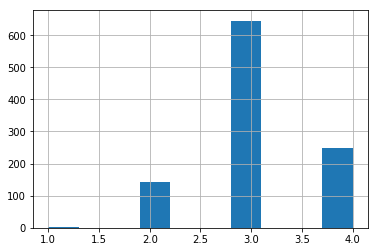

In [186]:
df.agreeableness.astype('int').hist()

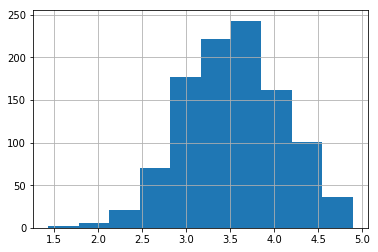

In [187]:
df.agreeableness.hist()

In [188]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['agreeableness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 235 ms, sys: 204 ms, total: 439 ms
Wall time: 365 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [189]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['agreeableness']

In [190]:
(yt > 5).sum()

0

In [191]:
skmetrics.mean_squared_error(yt, yp)

0.54580594729344734

In [192]:
skmetrics.r2_score(yt, yp)

-0.62829339713393439

In [193]:
scipy.stats.pearsonr(yt,yp)

(0.15051851230972041, 0.0077400293191707149)

## Conscientiousness evaluation

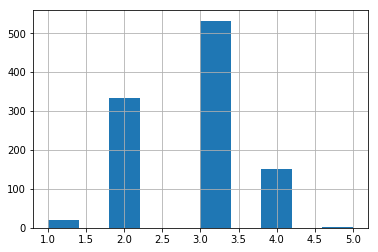

In [194]:
df.conscientiousness.astype('int').hist()

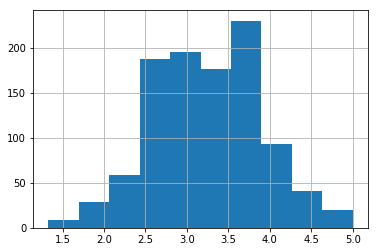

In [195]:
df.conscientiousness.hist()

In [196]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['conscientiousness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 266 ms, sys: 179 ms, total: 445 ms
Wall time: 380 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [197]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['conscientiousness']

In [198]:
skmetrics.mean_squared_error(yt, yp)

0.79693597756410262

In [199]:
skmetrics.r2_score(yt, yp)

-1.0713531818138713

In [200]:
scipy.stats.pearsonr(yt,yp)

(0.028006202788590551, 0.62215443173230101)

## Neuroticism evaluation

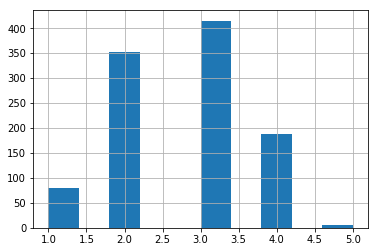

In [201]:
df.neuroticism.astype('int').hist()

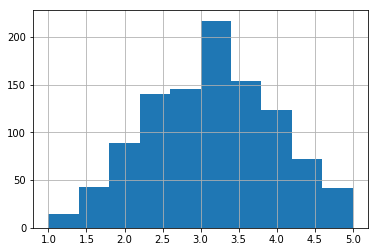

In [202]:
df.neuroticism.hist()

In [203]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['neuroticism'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


CPU times: user 291 ms, sys: 200 ms, total: 490 ms
Wall time: 537 ms


In [204]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['neuroticism']

In [205]:
(yt > 5).sum()

0

In [206]:
skmetrics.mean_squared_error(yt, yp)

1.4428472667378918

In [207]:
skmetrics.r2_score(yt, yp)

-1.072232228003529

In [208]:
scipy.stats.pearsonr(yt,yp)

(-0.0092931614795482738, 0.87012900670176885)

## Openess evaluation

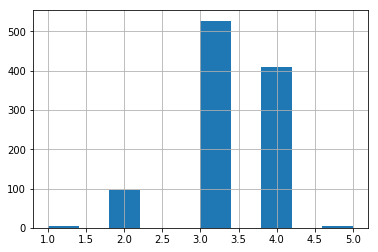

In [209]:
df.openness.astype('int').hist()

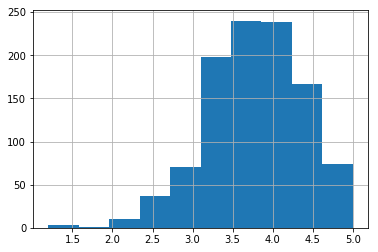

In [210]:
df.openness.hist()

In [211]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['openness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


CPU times: user 305 ms, sys: 200 ms, total: 505 ms
Wall time: 573 ms


In [212]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['openness']

In [213]:
(yt > 5).sum()

0

In [214]:
skmetrics.mean_squared_error(yt, yp)

0.79984775641025641

In [215]:
skmetrics.r2_score(yt, yp)

-1.1945087379691568

In [216]:
scipy.stats.pearsonr(yt,yp)

(0.007249894228040849, 0.89850800139979481)